In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


# Data Import

In [11]:
df = pd.read_csv("Project_1_Data.csv")

# Data Analysis & Visualization

In [46]:
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       860 non-null    float64
 1   Y       860 non-null    float64
 2   Z       860 non-null    float64
 3   Step    860 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 27.0 KB


,X,Y,Z,Step
0,9.375,3.0625,0.50,1
1,9.375,3.0625,0.51,1
2,9.375,3.0625,0.52,1
3,9.375,3.0625,0.53,1
4,9.375,3.0625,0.54,1


In [16]:
df["Step"].value_counts()

Step
9     251
8     221
7     148
1      24
2      24
3      24
4      24
5      24
6      24
10     24
11     24
12     24
13     24
Name: count, dtype: int64

<Axes: >

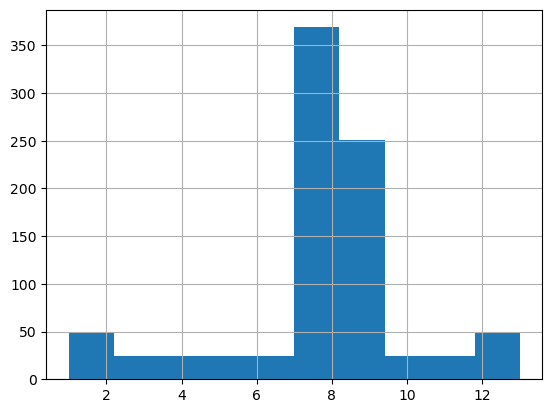

In [17]:
df["Step"].hist()

From the above, it can be seen that steps 7, 8, and 9 have more rows than the others. This could imply that these steps involve more movement/finer adjustments. In order to 
ensure all steps are proportionally represented, this will be used for the stratified sampling of the data, 

<Axes: >

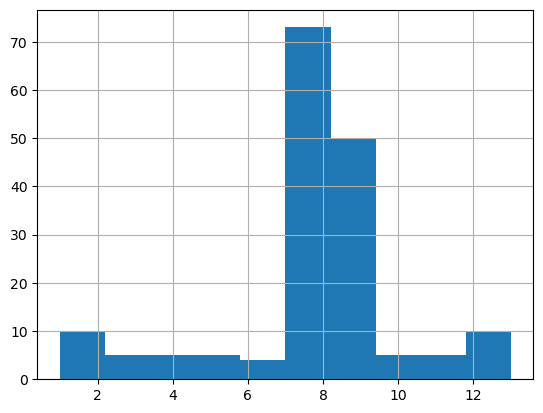

In [15]:
#Create an 80/20 train/test split

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(df, df["Step"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

test_set["Step"].hist()

In [19]:
#Create a copy of the training data for exploration
exp_set  = train_set.copy()

I would like to first visualze the range of each axis per step, to see if there are any correlations. For example, if Step 5 involves a lot of translation in the x-axis, but
minimal movement in the others

In [36]:
coord_range = exp_set.groupby('Step')[['X', 'Y', 'Z']].agg(['min', 'max'])


coord_range

X              Y             Z      
        min    max     min     max   min   max
Step                                          
1     9.375  9.375  3.0625  3.0625  0.50  0.72
2     9.375  9.375  3.0625  3.0625  0.74  0.97
3     9.375  9.375  3.0625  3.0625  0.98  1.21
4     9.375  9.375  3.0625  3.0625  1.22  1.45
5     9.375  9.375  3.0625  3.0625  1.46  1.69
6     9.375  9.375  3.0625  3.0625  1.71  1.92
7     8.575  8.575  5.6250  5.6250  0.36  1.82
8     6.945  9.145  5.1250  5.1250  0.35  2.00
9     0.375  2.875  5.8450  5.8450  0.00  2.35
10    0.000  0.000  3.0625  3.0625  0.98  1.21
11    0.000  0.000  3.0625  3.0625  1.22  1.44
12    0.000  0.000  3.0625  3.0625  1.46  1.69
13    0.000  0.000  3.0625  3.0625  1.70  1.93

# Correlation Analysis 

In [28]:
corr_matrix = exp_set.corr()

corr_matrix["Step"].sort_values(ascending = False)

Step    1.000000
Y       0.294097
Z       0.192925
X      -0.749724
Name: Step, dtype: float64

<Axes: xlabel='Z', ylabel='Step'>

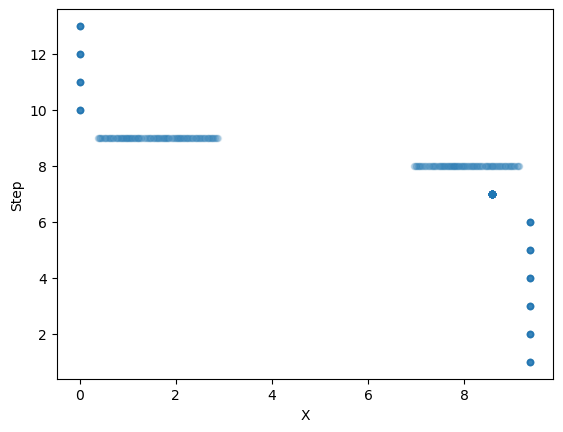

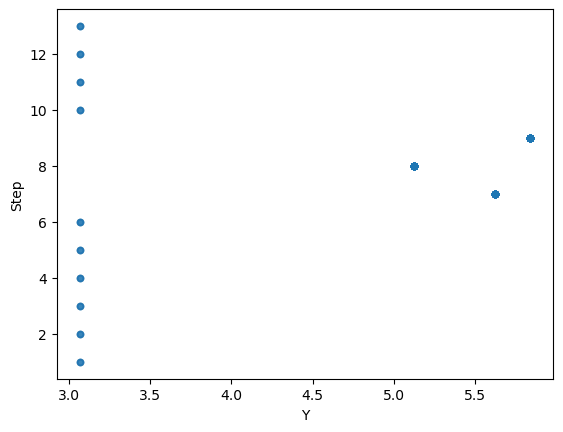

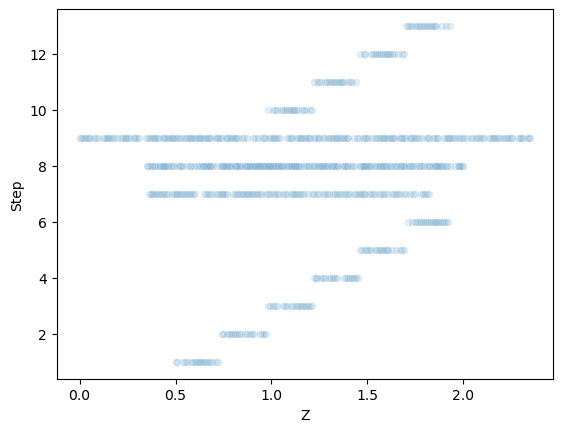

In [35]:
exp_set.plot(kind = "scatter", x = "X", y = "Step", alpha = 0.1)

exp_set.plot(kind = "scatter", x = "Y", y = "Step", alpha = 0.1)

exp_set.plot(kind = "scatter", x = "Z", y = "Step", alpha = 0.1)

# Training Data Preparation

Before performing any prepatory transformations of the datset, they first need to be split between observations and labels.

In [37]:
X_train = train_set.drop("Step", axis = 1)

y_train = train_set["Step"].copy()

In order to prepare the data for a training model, it first needs to be scaled, as the range of the different coordinate axes have different scales.

In [38]:
scaler = StandardScaler()

scaler.fit_transform(X_train)

array([[-1.50397952, -1.56731855,  0.78938332],
       [-1.50397952, -1.56731855,  0.36716295],
       [ 0.78272666,  0.24188724,  0.62145477],
       ...,
       [ 1.01960735, -1.56731855, -1.09141649],
       [ 0.36818546,  0.24188724, -1.59520216],
       [ 1.01960735, -1.56731855, -0.43889411]])

# Model Training

In [51]:
sdg_clf = SGDClassifier()

sdg_clf.fit(X_train, y_train)

test = np.array([0.36818546,  0.24188724, -1.59520216]).reshape(1, -1)

sdg_clf.predict(test)

c:\Users\ahadr\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([10], dtype=int64)

In [57]:
cross_val_score(sdg_clf, X_train, y_train, cv=10, scoring='accuracy')

array([0.65217391, 0.65217391, 0.84057971, 0.63768116, 0.69565217,
       0.62318841, 0.85507246, 0.73913043, 0.85294118, 0.58823529])

In [61]:
y_train_pred = cross_val_predict(sdg_clf, X_train, y_train, cv=5)

conf_mat = confusion_matrix(y_train, y_train_pred)

conf_mat

array([[ 11,   0,   4,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 11,   0,   4,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  8,   0,   4,   4,   3,   0,   0,   0,   0,   0,   0,   0,   0],
       [  4,   0,   4,   8,   3,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   1,   8,   7,   0,   0,   2,   0,   0,   0,   0,   0],
       [  0,   0,   0,   8,   5,   7,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  71,  48,   0,   0,   0,   0,   0],
       [  4,   0,   0,   8,   0,   0,  76,  89,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 201,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  11,   4,   4,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   7,   5,   4,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   4,   9],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   8,  11]],
      dtype=int64)

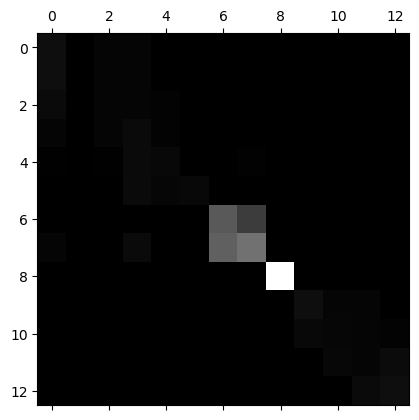

In [62]:
plt.matshow(conf_mat, cmap=plt.cm.gray)
plt.show()

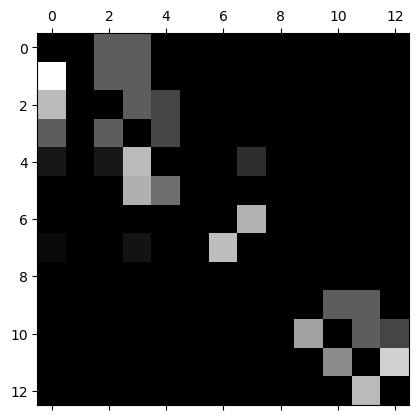

In [63]:
row_sums = conf_mat.sum(axis = 1, keepdims=True)
norm_conf_mat = conf_mat/row_sums

np.fill_diagonal(norm_conf_mat, 0)

plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()